In [116]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import advertools as adv
from PIL import Image
from wordcloud import WordCloud
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import networkx as nx
from afinn import Afinn
from textblob import TextBlob

In [107]:
# Ensure the NLTK punkt tokenizer is downloaded
nltk.download('punkt')
stop_words = set(stopwords.words('german')) 
nlp = spacy.load('de_core_news_sm')


# Apply lemmatization with POS tagging using spaCy
def ngrams_with_lemmatization(n_grams):
    lemmatized_ngrams = []
    
    for ngram in n_grams:
        lemmatized_ngram = []
        # Process the ngram using spaCy
        doc = nlp(" ".join(ngram))  # Join the ngram into a single string and process
        
        for token in doc:
            # Skip stopwords, punctuation, and words with fewer than 2 characters
                # Lemmatize based on POS (spaCy automatically uses the correct lemma)
            lemmatized_ngram.append(token.lemma_)
        
        lemmatized_ngrams.append(lemmatized_ngram)
    return lemmatized_ngrams

def count_words_in_list(str_list, num=20):

    # Count the number of occurrences of each string
    string_count = Counter(str_list)

    # Order the count of strings by number of occurrences
    ordered_counts = string_count.most_common()

    # Display the ordered counts
    print(ordered_counts[:num])
    
def get_embedding(word):
    model_path = "ibm-granite/granite-embedding-107m-multilingual"
    # Load the Sentence Transformer model
    model = SentenceTransformer(model_path)
    embedding = model.encode(word)  
    return np.squeeze(embedding)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LaptopBraun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:

# Path to the folder containing the txt files
folder_path = "Simulationen"

# List to collect rows
rows = []

# Iterate through all txt files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the file
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        
        for line in lines:
            # Split speaker and sentence if formatted like "P1: sentence"
            if ": " in line:
                speaker, content = line.split(": ", 1)
                # Tokenize the content into individual sentences
                sentences = sent_tokenize(content)
                for sentence in sentences:
                    # Append each sentence as a row
                    rows.append({"Speaker": speaker.strip(), "Sentence": sentence.strip()})

# Create DataFrame from collected rows
sentence_level_frame = pd.DataFrame(rows)

# Display the resulting DataFrame
print(sentence_level_frame.head(50))

   Speaker                                           Sentence
0       P1                                      Wer ist Pink?
1       P2                                   Bin beschäftigt!
2       P1  Okay, dann warte ich erstmal, ich bin bei dem ...
3       P3  Und wenn du wieder, wenn du wieder rein kommst...
4       P2                               Wie war, wo war der?
5       P1                                Lara, du bist Pink.
6       P2                                  Ne, ich bin Pink!
7       P1                                        Ah, Simone?
8       P1                    Ich bin draußen bei dem Grünen.
9       P1                         Ich bin jetzt ready, Lila.
10      P4                               Einmal zu Rosa raus.
11      P3                              Ah, du bist Rosa, P4?
12      P4  Ja, genau, aber ich muss erst mal schauen, wo ...
13      P1  Ich bin draußen und steh bei dem Grünen, aber ...
14      P1                            Was soll ich jetzt tun?
15      

In [67]:
word_rows = []
# Iterate through sentence-level DataFrame
for index, row in sentence_level_frame.iterrows():
    # Tokenize each sentence into words
    words = word_tokenize(row["Sentence"])
    filtered_words = [word for word in words if word.isalpha() and word.lower() and word.lower() not in stop_words]
    # Append each word with its associated metadata
    for word in filtered_words:
        word_rows.append({"Speaker": row["Speaker"], "Word": word})

# Create word-level DataFrame
word_level_frame_no_stopwords = pd.DataFrame(word_rows)

#same process with stopwords still included
word_rows = []
for index, row in sentence_level_frame.iterrows():
    # Tokenize each sentence into words
    words = word_tokenize(row["Sentence"])
    filtered_words = [word for word in words if word.isalpha()]
    # Append each word with its associated metadata
    for word in filtered_words:
        word_rows.append({"Speaker": row["Speaker"], "Word": word})
        
# Create word-level DataFrame
word_level_frame_with_stopwords = pd.DataFrame(word_rows)

# Display the resulting DataFrame
print(word_level_frame_no_stopwords.head(10))
print(word_level_frame_with_stopwords.head(10))

  Speaker         Word
0      P1          Wer
1      P1         Pink
2      P2  beschäftigt
3      P1         Okay
4      P1        warte
5      P1      erstmal
6      P1       Grünen
7      P1      draußen
8      P3         rein
9      P3       kommst
  Speaker         Word
0      P1          Wer
1      P1          ist
2      P1         Pink
3      P2          Bin
4      P2  beschäftigt
5      P1         Okay
6      P1         dann
7      P1        warte
8      P1          ich
9      P1      erstmal


In [69]:


# Create bigrams
bigrams_with_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_with_stopwords["Word"].values), 2)))

# Create trigrams
trigrams_with_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_with_stopwords["Word"].values), 3)))

# Display the results
print("Bigrams:", bigrams_with_stopwords)
print("Trigrams:", trigrams_with_stopwords)

# Create bigrams without stopwords
bigrams_no_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_no_stopwords["Word"].values), 2)))

# Create trigrams without stopwords
trigrams_no_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_no_stopwords["Word"].values), 3)))

# Display the results
print("Bigrams without stopwords:", bigrams_no_stopwords)
print("Trigrams without stopwords:", trigrams_no_stopwords)


Bigrams: [['wer', 'sein'], ['sein', 'Pink'], ['pink', 'Bin'], ['Bin', 'beschäftigen'], ['beschäftigen', 'Okay'], ['Okay', 'dann'], ['dann', 'warten'], ['warten', 'ich'], ['ich', 'erstmal'], ['erstmal', 'ich'], ['ich', 'sein'], ['sein', 'bei'], ['bei', 'der'], ['der', 'grüne'], ['grüne', 'draußen'], ['draußen', 'und'], ['und', 'wenn'], ['wenn', 'du'], ['du', 'wieder'], ['wieder', 'wenn'], ['wenn', 'du'], ['du', 'wieder'], ['wieder', 'rein'], ['rein', 'kommst'], ['kommsen', 'hier'], ['hier', 'links'], ['links', 'da'], ['da', 'hier'], ['hier', 'wie'], ['wie', 'sein'], ['sein', 'wo'], ['wo', 'sein'], ['sein', 'der'], ['der', 'Lara'], ['Lara', 'du'], ['du', 'sein'], ['sein', 'Pink'], ['Pink', 'Ne'], ['ne', 'ich'], ['ich', 'sein'], ['sein', 'Pink'], ['Pinke', 'Ah'], ['Ah', 'Simone'], ['Simone', 'ich'], ['ich', 'sein'], ['sein', 'draußen'], ['draußen', 'bei'], ['bei', 'der'], ['der', 'grüne'], ['grüne', 'ich'], ['ich', 'sein'], ['sein', 'jetzt'], ['jetzt', 'ready'], ['ready', 'Lila'], ['Lila'

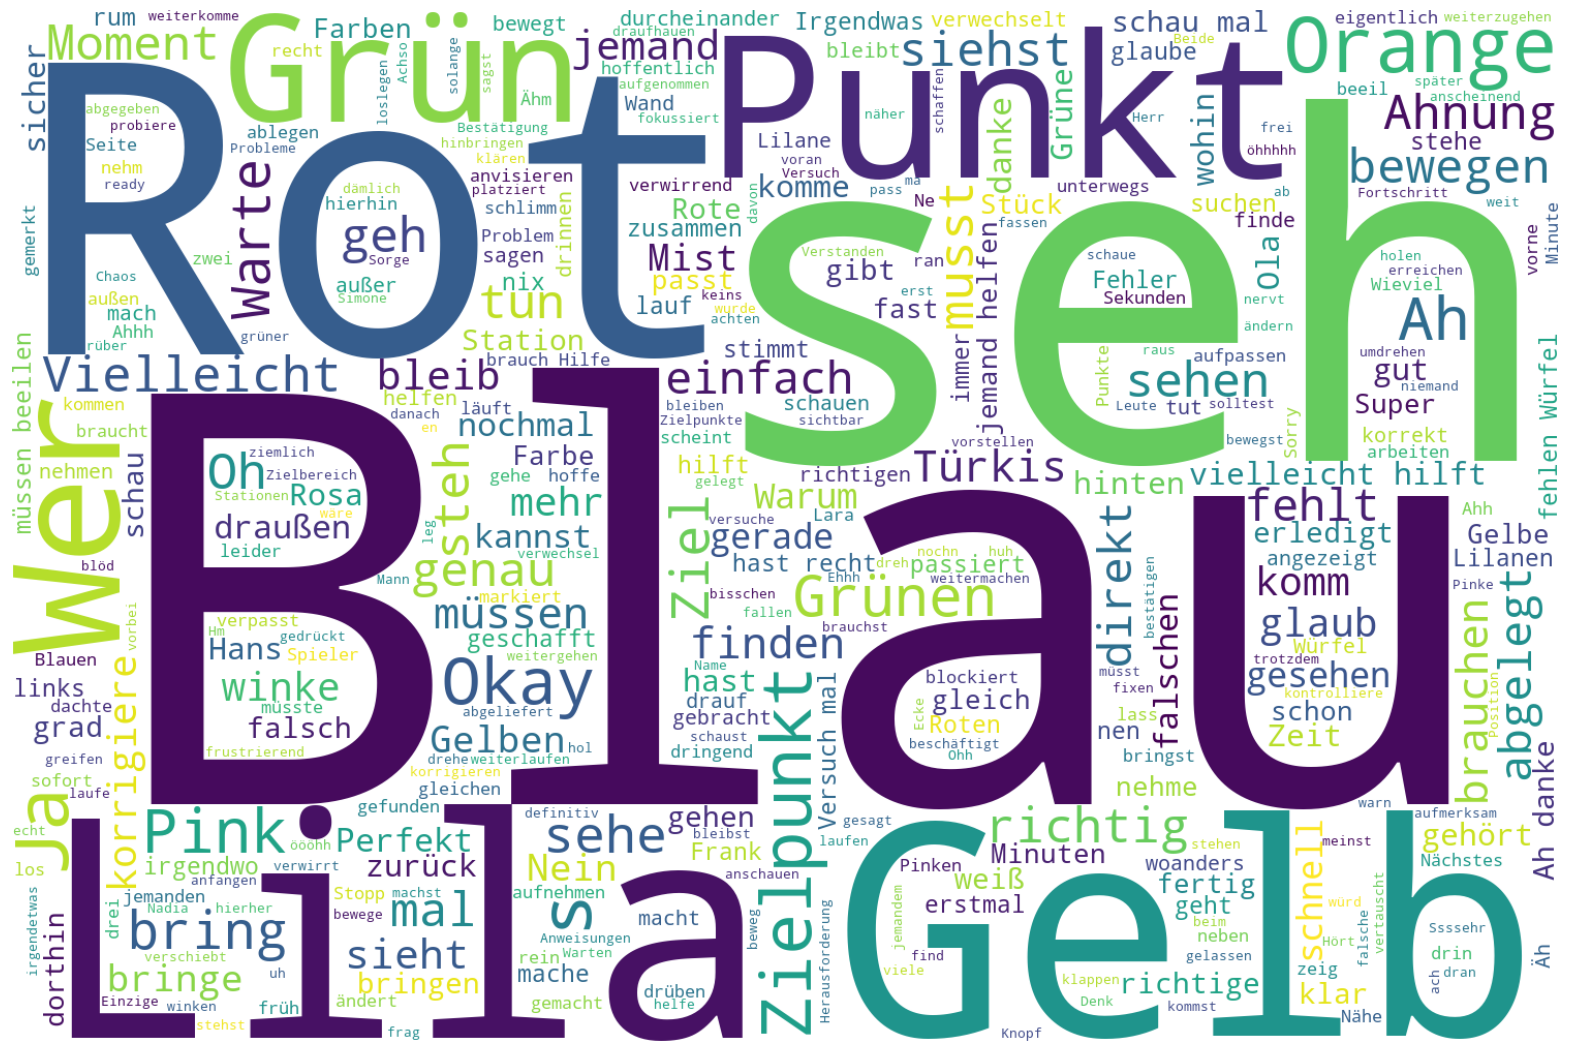

[('Blau', 120), ('seh', 79), ('Rot', 76), ('Lila', 62), ('Gelb', 58), ('Punkt', 51), ('Grün', 51), ('Orange', 45), ('Wer', 43), ('s', 39), ('Zielpunkt', 37), ('Ah', 34), ('Ja', 33), ('Pink', 29), ('Okay', 27), ('mal', 26), ('Grünen', 23), ('Ziel', 21), ('sehe', 20), ('bring', 19)]


In [78]:
def makeImage_uni(str_list):

    wc = WordCloud(width=1500, height=1000, background_color="white", max_words=400)
    # generate word cloud
    wc.generate(str_list)
   
    # show
    plt.figure( figsize=(20,20) )
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
makeImage_uni(' '.join(word_level_frame_no_stopwords["Word"].values))

count_words_in_list(word_level_frame_no_stopwords["Word"].values, 20)

In [ ]:
Farben und Verben. Nicht besonders aussagekräftig.

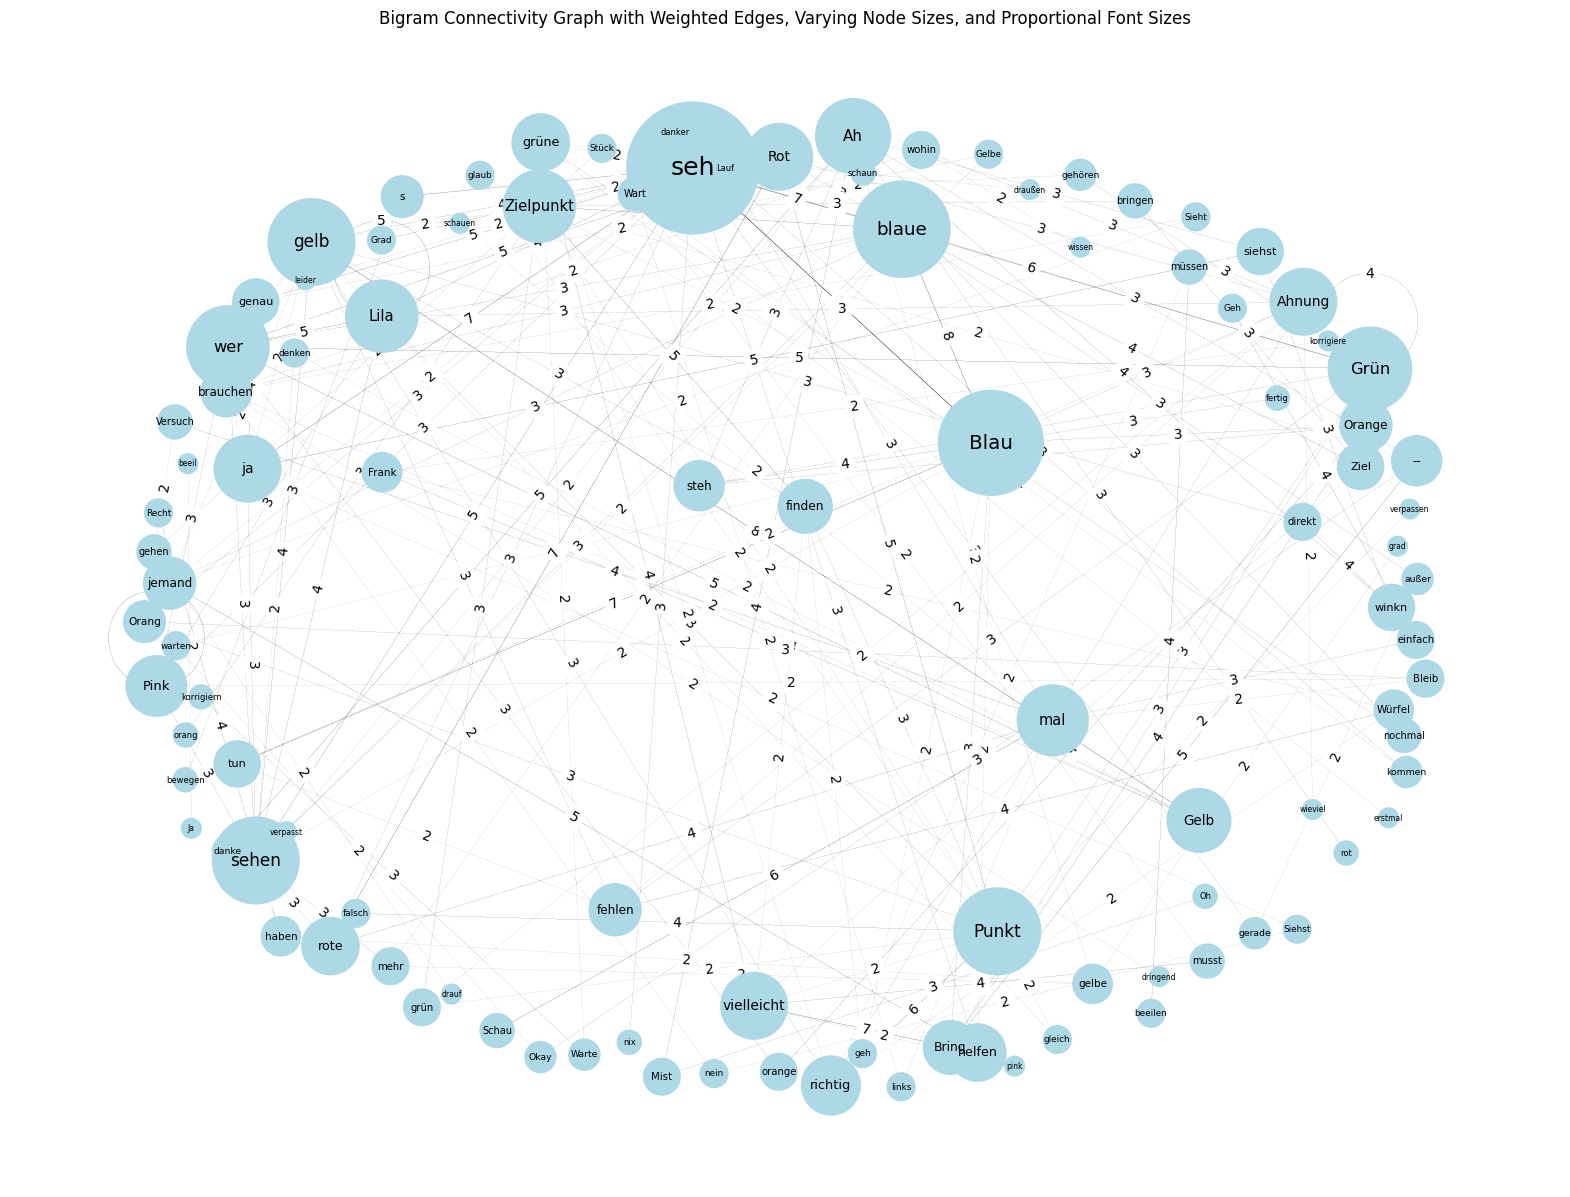

In [88]:
# Create a graph
G = nx.Graph()

bigram_tuples = [tuple(bigram) for bigram in bigrams_no_stopwords]

# Count frequencies of each bigram tuple
bigram_counts = Counter(bigram_tuples).most_common(200)
# Adding edges from the data
for (word1, word2), weight in bigram_counts:
    G.add_edge(word1, word2, weight=weight)

plt.figure(figsize=(20, 15))
# Position nodes using the spring layout
pos = nx.spring_layout(G, seed=42, k = 3)

# Calculate node sizes based on the sum of edge weights (scaled for visibility)
node_sizes = [sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()]
scaled_node_sizes = [size / 0.01 for size in node_sizes]  # Adjust size scale as needed

# Draw the nodes with increased size
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=scaled_node_sizes)

# Draw the edges with varying width based on the weight
edge_widths = [G[u][v]['weight'] / 50 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths)

# Create a font size list based on node sizes (simple linear scaling)
font_sizes = [np.log(size)+0.05*size / 50 for size in scaled_node_sizes]  # Scale font size in relation to node size

# Draw labels for nodes with varying font sizes
for node, font_size in zip(G.nodes(), font_sizes):
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size)

# Edge labels with weights
edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Bigram Connectivity Graph with Weighted Edges, Varying Node Sizes, and Proportional Font Sizes")
plt.axis('off')  # Turn off the axis
plt.show()

Keine besonderen Zusammenhänge erkennbar

In [114]:


test = word_level_frame_with_stopwords.iloc[0:10]
test
# Iterate through the DataFrame and get embeddings
embeddings = test['Word'].apply(get_embedding)

# Create new columns for each embedding dimension
embedding_columns = [f"embedding_{i}" for i in range(384)]
test[embedding_columns] = pd.DataFrame(embeddings.tolist(), index=test.index)

# Display the updated DataFrame
print(test)

2025-01-06 22:35:51,615 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:35:51,616 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


C:\Users\LaptopBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:35:55,460 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:35:55,461 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:35:59,687 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:35:59,688 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:03,395 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:03,396 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:08,207 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:08,209 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:12,392 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:12,393 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:16,922 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:16,923 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:21,566 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:21,567 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:25,942 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:25,942 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-06 22:36:30,170 | INFO | SentenceTransformer.py:208 | __init__ | Use pytorch device_name: cpu
2025-01-06 22:36:30,171 | INFO | SentenceTransformer.py:216 | __init__ | Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\1203848055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[embedding_columns] = pd.DataFrame(embeddings.tolist(), index=test.index)
C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\1203848055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[embedding_columns] = pd.DataFrame(embeddings.tolist(), index=test.index)
C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\1203848055.py:8: SettingWithCopyWarning: 
A value is trying to

  Speaker         Word  embedding_0  embedding_1  embedding_2  embedding_3   
0      P1          Wer     0.009176     0.000862    -0.011104     0.043096  \
1      P1          ist     0.021004     0.042139     0.009711     0.048662   
2      P1         Pink     0.010605     0.096581     0.015761     0.009150   
3      P2          Bin     0.024015     0.031165    -0.002514     0.003809   
4      P2  beschäftigt     0.021371     0.015308    -0.017933     0.039306   
5      P1         Okay     0.021117     0.037715     0.031892     0.053561   
6      P1         dann     0.061963     0.060571     0.033437     0.053505   
7      P1        warte     0.035677     0.047997     0.026643     0.043477   
8      P1          ich     0.006595     0.072904    -0.008226    -0.011615   
9      P1      erstmal     0.025431     0.095804     0.070381     0.045272   

   embedding_4  embedding_5  embedding_6  embedding_7  ...  embedding_374   
0     0.040944    -0.017924     0.047275     0.018122  ...      

C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\1203848055.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[embedding_columns] = pd.DataFrame(embeddings.tolist(), index=test.index)
C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\1203848055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[embedding_columns] = pd.DataFrame(embeddings.tolist(), index=test.index)
C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\1203848055.py:8: PerformanceWarning: DataFrame is highly fragmented.  Thi

In [117]:
columns_to_standardize = test.columns[2:]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform only the sliced columns
test[columns_to_standardize] = scaler.fit_transform(test[columns_to_standardize])

C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_18276\119786429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columns_to_standardize] = scaler.fit_transform(test[columns_to_standardize])
